<a href="https://colab.research.google.com/github/YenaChoi00/ML-Final-Project/blob/main/CIFAR10_Classification_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification. 

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

class : 10개
나오는 output : 4개의 batch size에 대해 4*10
output feature가 10이 되는..

#수정해야 할 부분
data preprocessing
network
loss function - cross entro..는 그대로 두기! 다른거 추가해서 사용해도 됨
adam도 바꿔도 됨,
scheduls???? 이런것도 바꿔도 됨
regulization 추가 가능
epochs 수 조정

In [ ]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

# os와 sys: 파일 및 시스템 관련 기능을 제공하는 모듈입니다.
# torch: PyTorch 라이브러리를 import합니다.
# nn (torch.nn): 신경망 모델 구축을 위한 클래스들을 제공하는 모듈입니다.
# functional (torch.nn.functional): 활성화 함수, 손실 함수 등과 같은 기능을 포함하는 함수들을 제공하는 모듈입니다.
# 그리고 CIFAR-10 데이터셋을 사용하기 위해 torchvision 라이브러리에서 transforms와 datasets를 import하고 있습니다. 데이터 시각화를 위한 matplotlib.pyplot과 배열 연산을 위한 numpy도 import하고 있습니다.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np


from torchsummary import summary as summary_  # 모델의 summary 보기 위해 추가

In [ ]:
# Set the device

# 이 코드는 사용 가능한 GPU가 있는 경우 디바이스를 CUDA로 설정하고, 그렇지 않은 경우 CPU로 설정합니다.

# torch.cuda.is_available(): CUDA가 사용 가능한지 확인하는 함수입니다. GPU가 사용 가능한 경우 True를 반환하고, 그렇지 않은 경우 False를 반환합니다.
# device 변수에는 'cuda' 또는 'cpu'가 할당됩니다. 그리고 print(device)를 통해 현재 설정된 디바이스를 출력합니다.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [ ]:
# 이 코드는 CIFAR-10 데이터셋을 불러와서 전처리를 수행하고, 훈련 및 테스트 데이터로 나누는 부분입니다.

# transforms.Compose: 여러 개의 데이터 전처리 작업을 한 번에 적용하기 위한 함수입니다. 인자로 전달된 전처리 함수들을 순차적으로 적용합니다.
# transforms.Resize: 이미지 크기를 조정하는 전처리 함수입니다. CIFAR-10의 이미지는 32x32 크기로 조정됩니다.
# transforms.ToTensor: 이미지를 PyTorch Tensor로 변환하는 전처리 함수입니다.
# transforms.Normalize: 이미지의 픽셀 값을 정규화하는 전처리 함수입니다. 평균과 표준편차를 사용하여 정규화합니다. 여기서는 각 채널의 평균과 표준편차를 (0.5, 0.5, 0.5)로 설정하여 정규화합니다.
# transforms_cifar10은 위의 전처리 함수들을 순차적으로 적용하는 변환 파이프라인입니다.

# trainset: CIFAR-10 훈련 데이터셋을 생성합니다. root는 데이터셋의 다운로드 위치를 지정합니다. train=True는 훈련 데이터셋을 의미하며, download=True는 데이터셋이 없는 경우 다운로드합니다. transform에는 위에서 정의한 transforms_cifar10를 전달하여 데이터셋의 전처리를 수행합니다.
# trainloader: 훈련 데이터셋을 미니배치로 나누고 데이터를 섞어주는 데이터 로더입니다. batch_size=4는 미니배치의 크기를 4로 설정합니다. shuffle=True는 데이터를 섞어서 무작위로 골고루 가져올 수 있도록 합니다. num_workers=2는 데이터 로딩을 위한 병렬 작업자의 수를 지정합니다.
# 위와 마찬가지로, testset과 testloader는 테스트 데이터셋에 대한 데이터셋과 데이터 로더를 생성하는 역할을 합니다.

# 마지막으로, classes는 CIFAR-10 데이터셋의 클래스들을 나타내는 튜플입니다. 각 클래스는 "plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"으로 표현됩니다.

train_cifar10 = transforms.Compose([transforms.Resize((32, 32)),     ## 32.32는 수정불가
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomRotation(10),
                                  transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # 여기에 preprocessing할 때 추가적으로 넣어도 됨. preprocessing은 tensor로 바뀌기 전에 
                                 ])

# # color Jitter 조정, randomvertival flip
# train_cifar10 = transforms.Compose([transforms.Resize((32, 32)),     ## 32.32는 수정불가
#                                   transforms.RandomHorizontalFlip(),
#                                   transforms.RandomVerticalFlip(),
#                                   transforms.RandomRotation(10),
#                                   transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
#                                   transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#                                   transforms.ToTensor(),
#                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # 여기에 preprocessing할 때 추가적으로 넣어도 됨. preprocessing은 tensor로 바뀌기 전에 
#                                  ])



test_cifar10 = transforms.Compose([transforms.Resize((32, 32)),     ## 32.32는 수정불가
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # 여기에 preprocessing할 때 추가적으로 넣어도 됨. preprocessing은 tensor로 바뀌기 전에 
                                 ])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)    # batch size 수정가능. shuffle : True/False 선택가능, num_workers는 CPU 수 그래서  수정 불필요

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset 10개의 dataset. 수정 불필요
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


  dog plane   cat truck


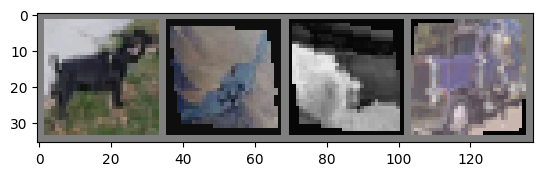

In [ ]:
# 이 코드는 데이터셋에서 가져온 예시 이미지들을 시각화하고, 해당 이미지들의 라벨을 출력하는 부분입니다.

# imshow: 이미지를 시각화하기 위한 함수입니다. 입력된 이미지를 0.5로 나누고 0.5를 더하여 범위를 [0, 1]로 변환합니다. 그리고 이미지를 numpy 배열로 변환하고, plt.imshow를 사용하여 이미지를 표시합니다.
# dataiter: trainloader를 이터레이터로 변환합니다.
# imgs, labels: next(dataiter)를 통해 다음 미니배치의 이미지와 라벨을 가져옵니다.
# torchvision.utils.make_grid: 이미지들을 그리드 형태로 결합하여 하나의 이미지로 만들어줍니다.
# plt.imshow를 사용하여 결합된 이미지를 표시합니다.
# ' '.join('%5s' % classes[labels[j]] for j in range(4)): 4개의 이미지에 대한 라벨을 출력합니다. labels에는 이미지들의 정답 라벨이 들어있고, classes에는 CIFAR-10 클래스들이 들어있습니다.
#  이를 활용하여 정답 라벨을 문자열로 변환하고, ' '.join()을 사용하여 공백을 포함하여 출력합니다.

# Examples of dataset
# 예시 이미지를 가져온 것
def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [ ]:
# VGG Model

# 이 코드는 CIFAR-10 이미지 분류를 위한 VGG11 모델을 정의하는 부분입니다.

# cfg: VGG11 아키텍처의 구성을 나타내는 딕셔너리입니다. 딕셔너리의 값은 컨볼루션 레이어와 풀링 레이어의 출력 채널 수를 나타냅니다.
# VGG11: nn.Module을 상속하는 클래스입니다. 이 클래스는 모델의 구조와 forward 연산을 정의합니다.
# __init__ 메서드: 모델의 레이어들을 초기화합니다. make_layers 함수를 호출하여 컨볼루션 레이어와 분류기 레이어를 생성합니다.
# self.features: 컨볼루션 레이어들로 구성된 특성 추출기입니다. make_layers 함수를 통해 생성된 레이어들을 포함합니다.
# self.classifier: 분류기 레이어입니다. 512개의 입력을 받아 10개의 출력을 생성하는 선형 레이어입니다.
# make_layers 메서드: 주어진 구성(cfg)에 따라 컨볼루션 레이어들을 생성하여 순차적으로 연결합니다.
# layers 리스트에 컨볼루션, 배치 정규화 및 ReLU 활성화 함수를 포함한 레이어들을 추가합니다.
# nn.MaxPool2d를 사용하여 풀링 레이어를 추가합니다.
# forward 메서드: 입력 데이터를 받아 순전파 연산을 수행합니다. 특성 추출기를 통과한 후에는 2D 텐서를 1D로 평탄화하여 분류기에 입력으로 제공합니다.
# net: VGG11 클래스의 인스턴스를 생성하고, to(device)를 사용하여 모델을 지정한 디바이스 (GPU 또는 CPU)로 이동합니다.

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
    }  

class VGG16(nn.Module):
    def __init__(self,
                 in_channels=3,
                 num_classes=1000,
                 init_weights=True,
                 model='VGG16'):
        super(VGG16, self).__init__()
        self.in_channels = in_channels
        self.features = self.make_layers(cfg[model])
        self.classifier = nn.Linear(512, 10)

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

        if init_weights == True:
          self._initialize_weights()


    def forward(self, x):
        #out = F.normalize(x, dim=0)
        #out = F.normalize(x, p=2.0, dim=1, eps=1e-12, out=None)
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    # def make_layers(self, cfg):
    def make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

    def _initialize_weights(self):
      # modules -> Sequential의 모든 layer
      for m in self.modules():
        # Conv layer 초기화
        if isinstance(m, nn.Conv2d):
            # he_initialization(ReLU에 최적화)
            nn.init.kaiming_normal_(m.weight,
                                    mode='fan_out',
                                    nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.normal_(m.bias, 0)


net = VGG16().to(device)

In [ ]:
print(net)
summary_(net, input_size=(3, 32, 32), device=device)

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
# Loss function and optimizer

# 이 코드는 손실 함수와 옵티마이저를 설정하는 부분입니다.

# loss_fun: 분류 작업을 위한 손실 함수로서, nn.CrossEntropyLoss()를 사용합니다. 이 함수는 다중 클래스 분류에서 사용되며, 입력으로 예측값과 정답 라벨을 받아 손실을 계산합니다.
# optimizer: 모델의 파라미터를 업데이트하는데 사용되는 최적화 알고리즘입니다. 여기서는 Adam 옵티마이저를 사용하며, net.parameters()를 통해 모델의 학습 가능한 파라미터들을 전달합니다.
#  lr=0.001은 학습률(learning rate)로서, 파라미터 업데이트의 크기를 결정합니다.
# scheduler: 학습률 스케줄러입니다. 여기서는 StepLR 스케줄러를 사용합니다. step_size는 학습률을 조절하는 주기(step size)를 나타내며, gamma는 학습률을 감소시키는 비율을 나타냅니다. 주어진 주기마다 학습률을 감소시키는 데 사용됩니다.



loss_fun = nn.CrossEntropyLoss()    # -log에 대해 값들이 10개로 나옴. 이 값들에 exponential을 취함. 왜 하
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
# optimizer의 매개변수로 weight decay value를 넣어줄 수 있는데, 이때 이 값은 앞선 식에서 lambda를 의미한다. 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # 지? log를 활용하기 때문에 계산을 편하게 하기 위해. CrossEntropyLoss는 필수 활용해라

# **Train the network**

Train your own network using the above loss function and optimizer.

In [ ]:
# tensor board
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./logs/vgg16')

In [ ]:
# 이 코드는 모델을 학습시키는 부분입니다.

# epochs: 전체 데이터셋을 몇 번 반복하여 학습할지를 결정하는 변수입니다.
# for epoch in range(epochs):: 주어진 epoch 수만큼 반복합니다.
# loss_tmp와 epoch_loss는 손실(loss) 값을 기록하기 위한 변수입니다.
# for i, data in enumerate(trainloader, start=0):: trainloader를 이용하여 미니배치 단위로 데이터를 가져옵니다. i는 현재 미니배치의 인덱스를 나타냅니다.
# inputs, labels = data: 데이터로부터 입력(inputs)과 라벨(labels)을 가져옵니다.
# inputs = inputs.to(device), labels = labels.to(device): 데이터를 지정한 디바이스(GPU 또는 CPU)로 이동합니다.
# outputs = net(inputs): 입력을 모델에 전달하여 예측값을 계산합니다.
# loss = loss_fun(outputs, labels): 모델의 출력과 정답 라벨을 사용하여 손실을 계산합니다.
# optimizer.zero_grad(): 옵티마이저의 그래디언트를 초기화합니다.
# loss.backward(): 손실에 대한 역전파를 수행하여 그래디언트를 계산합니다.
# optimizer.step(): 그래디언트를 사용하여 모델의 파라미터를 업데이트합니다.
# loss_tmp += loss.data, epoch_loss += loss.data: 현재 미니배치의 손실 값을 누적합니다.
# if i % 5000 == 4999:: 일정한 주기로 손실 값을 출력합니다. 여기서는 매 5000번째 미니배치마다 출력합니다.
# scheduler.step(): 학습률 스케줄러를 통해 학습률을 업데이트합니다.
# print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1))): 에포크마다 손실 값을 출력합니다.
# print('Finished Training'): 학습이 완료되었음을 출력합니다.

# Train the model
epochs =30  # number of epochs  

for epoch in range(epochs):

    loss_tmp = 0.0
    epoch_loss = 0.0 
    
    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)    # cpu에 있는 코드를 gpu로 보내줌
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = loss_fun(outputs, labels)

        # Optimize the network 
        optimizer.zero_grad()
        loss.backward()   # backpropagation 해서 gradient 구한다
        optimizer.step()

        loss_tmp += loss.data
        epoch_loss += loss.data

        if i % 5000 == 4999:    # Print loss every 5000 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0

    # Update the learning rate according to the learnig rate scheduler
    scheduler.step()

    # tensorboard: train_loss 기록
    writer.add_scalar('Loss/train', epoch_loss / (i+1), epoch)

    # Print the epoch loss
    print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1)))

print('Finished Training')

[Epoch - 1, Iteration -  5000] Loss: 1.839
[Epoch - 1, Iteration - 10000] Loss: 0.742
[Epoch - 1] Loss: 1.593
[Epoch - 2, Iteration -  5000] Loss: 1.227
[Epoch - 2, Iteration - 10000] Loss: 0.557
[Epoch - 2] Loss: 1.146
[Epoch - 3, Iteration -  5000] Loss: 0.983
[Epoch - 3, Iteration - 10000] Loss: 0.475
[Epoch - 3] Loss: 0.955
[Epoch - 4, Iteration -  5000] Loss: 0.861
[Epoch - 4, Iteration - 10000] Loss: 0.421
[Epoch - 4] Loss: 0.846
[Epoch - 5, Iteration -  5000] Loss: 0.775
[Epoch - 5, Iteration - 10000] Loss: 0.379
[Epoch - 5] Loss: 0.762
[Epoch - 6, Iteration -  5000] Loss: 0.703
[Epoch - 6, Iteration - 10000] Loss: 0.339
[Epoch - 6] Loss: 0.686
[Epoch - 7, Iteration -  5000] Loss: 0.644
[Epoch - 7, Iteration - 10000] Loss: 0.319
[Epoch - 7] Loss: 0.638
[Epoch - 8, Iteration -  5000] Loss: 0.599
[Epoch - 8, Iteration - 10000] Loss: 0.304
[Epoch - 8] Loss: 0.602
[Epoch - 9, Iteration -  5000] Loss: 0.571
[Epoch - 9, Iteration - 10000] Loss: 0.282
[Epoch - 9] Loss: 0.564
[Epoch - 1

In [ ]:
writer.close()

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network. 

The closer the accuray is to 100%, the better the network classifies the input image.

In [ ]:
# dataiter_test = iter(testloader): 테스트 데이터 로더에서 데이터를 가져옵니다.
# img_test, labels_test = next(dataiter_test): 테스트 데이터에서 이미지와 라벨을 가져옵니다.
# imshow(torchvision.utils.make_grid(img_test)): 테스트 이미지를 시각화하여 출력합니다.
# print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4))): 실제 정답 라벨을 출력합니다.
# img_test = img_test.to(device), labels_test = labels_test.to(device): 데이터를 지정한 디바이스(GPU 또는 CPU)로 이동합니다.
# outputs_test = net(img_test): 테스트 이미지를 모델에 전달하여 예측값을 계산합니다.
# _, predicted = torch.max(outputs_test.data, 1): 예측값 중 가장 큰 값을 가지는 클래스를 선택합니다.
# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4))): 예측된 클래스를 출력합니다.

# Test the trained model with sample

# test코드는 고치지 말고 그대로 사용해도 ㄱㅊ

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
# epochs: 전체 데이터셋을 몇 번 반복하여 학습할지를 결정하는 변수입니다.
# for epoch in range(epochs):: 주어진 epoch 수만큼 반복합니다.
# loss_tmp와 epoch_loss는 손실(loss) 값을 기록하기 위한 변수입니다.
# for i, data in enumerate(trainloader, start=0):: trainloader를 이용하여 미니배치 단위로 데이터를 가져옵니다. i는 현재 미니배치의 인덱스를 나타냅니다.
# inputs, labels = data: 데이터로부터 입력(inputs)과 라벨(labels)을 가져옵니다.
# inputs = inputs.to(device), labels = labels.to(device): 데이터를 지정한 디바이스(GPU 또는 CPU)로 이동합니다.
# outputs = net(inputs): 입력을 모델에 전달하여 예측값을 계산합니다.
# loss = loss_fun(outputs, labels): 모델의 출력과 정답 라벨을 사용하여 손실을 계산합니다.
# optimizer.zero_grad(): 옵티마이저의 그래디언트를 초기화합니다.
# loss.backward(): 손실에 대한 역전파를 수행하여 그래디언트를 계산합니다.
# optimizer.step(): 그래디언트를 사용하여 모델의 파라미터를 업데이트합니다.
# loss_tmp += loss.data, epoch_loss += loss.data: 현재 미니배치의 손실 값을 누적합니다.
# if i % 5000 == 4999:: 일정한 주기로 손실 값을 출력합니다. 여기서는 매 5000번째 미니배치마다 출력합니다.
# scheduler.step(): 학습률 스케줄러를 통해 학습률을 업데이트합니다.
# print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1))): 에포크마다 손실 값을 출력합니다.
# print('Finished Training'): 학습이 완료되었음을 출력합니다.


# Test the trained model with overall test dataset

correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)
    
    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 11 %

## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images:  68%
## [VGG11 / Training 10 epochs] Accuracy of the network on the 10,000 test images: 79 %

## schedular 변경, 68%
# epoch 50 2시간 이상 소요.... 89%
# epoch 10 30분 소요 ...83%
# 데마개 no initialize weight epoch 10 ...77%
# 데마개 with initialize wiehgt epoch 10 ...80%
# 데마개 with initialize wiehgt epoch 30 ... 1시간 30분 소요 예상하나.. 오늘은 여기까지 

# 다시 이전 모델로 돌아옴
# epoch 5... 20분 소요 ... 78%
# epoch 5, def forward(self, x):    out = F.normalize(x, dim=0) ... 77%
# epoch 10, def forward(self, x):    out = F.normalize(x, dim=0) ... 83%
# epoch 30 def forward(self, x):    out = F.normalize(x, dim=0) ... 88%

# batch normalization이나 dropout, 기타 l1norm, l2norm 의 regularization
# epoch 10   l2. weight_deacy=0.9 ... 10% (왜지

# epoch 10 weight decay 없애고 data augmentation 수정.. 80%
# epoch 30 ... data augmentation 수정 ... 81% ( 과도한 augmentation도 accuracy를 떨어뜨릴 수 있구나)
# epoch 10 data augmentation에서 hue가 바뀌었을 때 accuracy가 떨어지는 것 같음 ... 76%


# 6/4일 epoch 50 ... 89%

# 특이점 : 앞서 Color Jitter (0.2, 0.2, 0.2, 0.1)로 변경, 
# RandomHorizontalFlip()해서 최종 결과 76% 나왔음에도 불구하고 (10epoch 기준, 변환 이전엔 77%) Predicted에서 cat, ship, ship, plane으로 라벨을 모두 맞춤. 
# 그러나 현 epoch50을 돌린 모델은 89%가 나옴에도 불구하고 cat, ship, car, plane으로 라벨을 제대로 맞추지 못하는 모습을 보임.

# 주요 변환 : 
# DataLoader → Augmentation
# DataLoader - batch size 4 변경 / https://inhovation97.tistory.com/32 : 참고 글. batch size와 lr의 상관관계. (lr과 batch size가 작도록 설정함)
# Your own CNN - 인터넷에서 기존 모델 사용 / Your own CNN - 인터넷에서 기존 모델 사용

# Loss function and optimizer - Adam 그대로 사용
#   learning rate = 0.0001
#   step size : 5
#   gamma = 0.9

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=/content/logs